# Salted

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader, random_split

import os 
import glob
import cv2
import itertools

In [2]:
class Gait_Dataset_Salted(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.inputs_acc, self.inputs_gyr, self.stride_length = get_sensor_salted(file_path)

    def __len__(self) :
        return len(self.inputs_acc)
    
    def __getitem__(self, idx):
        return self.inputs_acc[idx], self.inputs_gyr[idx], self.stride_length[idx]

In [126]:
def get_event_salted(file_path):
    
    df = pd.read_csv(file_path, skiprows=2)
    
    # 압력값 불러오기
    prs = df.filter(regex="R_value")
    prs_mean = np.mean(prs.iloc[:, 0:4], axis=1) 
    
    # Gaussian Filter : Smoothing pressure data
    prs_mean_gf = pd.Series(scipy.ndimage.gaussian_filter1d(prs_mean, 2))
    
    # Level Shift 
    lev_idx = prs_mean_gf > 2 # 가우시안 필터로 인해 0이 아닌 값으로 threshold 설정
    prs_lev = lev_idx.map(lambda x : 1 if x else 0)
    
    # HS, TO Index 추출
    event_idx = []
    for i in range(len(prs_lev)-1):
        if (prs_lev[i] - prs_lev[i+1]) != 0:
            event_idx.append(i)
            
    # HS 이벤트가 먼저 시작하도록 : 나중에 lev shift를 통해 구하는 방법으로 변경하는 것도 괜찮을 듯
    if np.diff(event_idx)[0] < np.diff(event_idx)[1]: # Swing Phase가 Stand Phase보다 길다는 것을 가정 : 장애 데이터에서도 확인 필요
        del event_idx[0]
    
    
    return event_idx

def get_sensor_salted(file_path):
    inputs_acc = []
    inputs_gyr = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS만 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = (acc / 1000) * 9.8066
    #     acc_z = acc_z - np.mean(acc_z) # z축(상하)에 적용되는 중력가속도 제거 : 추가확인 필요

        # Normalization
        scaler = MinMaxScaler()
        acc_norm = scaler.fit_transform(acc)
        gyr_norm = scaler.fit_transform(gyr)

        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
#             inputs_acc.append(cv2.resize(acc_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300)))
#             inputs_gyr.append(cv2.resize(gyr_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300)))
            inputs_acc.append(np.transpose(cv2.resize(acc_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
            inputs_gyr.append(np.transpose(cv2.resize(gyr_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))

            #             inputs_gyr.append(acc_norm[event_hs[i-1]:event_hs[i]])
    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_acc, inputs_gyr, stride_length


In [294]:
file_path = "D:\gait_dataset/salted/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path)

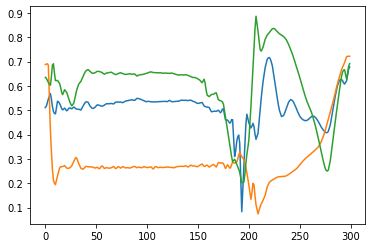

In [296]:
plt.plot(np.transpose(inputs_acc[0]))

AttributeError: 'numpy.ndarray' object has no attribute 'ToTensor'

In [28]:

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

In [128]:
input_size = 300
hidden_size = 64
num_layers = 1

In [215]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

lstm_acc = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
lstm_gyr = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
lstm_acc_b = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
lstm_gyr_b = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)

In [282]:
acc = torch.rand(16, 3, 300)
gyr = torch.rand(16, 3, 300)
acc_b = torch.rand(3, 16, 300)
gyr_b = torch.rand(3, 16, 300)

In [283]:
o_acc, (h_acc, _) = lstm_acc(acc)
o_gyr, (h_gyr, _) = lstm_gyr(gyr)
o_acc_b, (h_acc_b, _) = lstm_acc_b(acc_b)
o_gyr_b, (h_gyr_b, _) = lstm_gyr_b(gyr_b)

In [292]:
merged_state = torch.cat([s for s in h_acc], 1)
merged_state = merged_state.squeeze(0).unsqueeze(2)
print(o_acc.shape)
print(merged_state.shape)

torch.Size([16, 3, 64])
torch.Size([16, 64, 1])


In [273]:
merged_state_b = torch.cat([s for s in h_b], 1)
print(merged_state_b.shape)

torch.Size([16, 64])


In [274]:
merged_state_b = merged_state_b.squeeze(0).unsqueeze(2)
print(merged_state_b.shape)

torch.Size([16, 64, 1])


In [235]:
merged_state = torch.cat([s for s in h], 1)
print(merged_state.shape)

torch.Size([16, 64])


In [236]:
merged_state = merged_state.squeeze(0).unsqueeze(2)
print(merged_state.shape)

torch.Size([16, 64, 1])


In [222]:
o_concat.shape

torch.Size([16, 3, 128])

In [293]:
h_concat = torch.cat((h_acc.view(-1, 64), h_gyr.view(-1, 64)), dim=1)
h_concat = h_concat.squeeze(0).unsqueeze(2)

o_concat = torch.cat((o_acc, o_gyr), dim=2)
print(o_concat.size())
print(h_concat.size())

torch.Size([16, 3, 128])
torch.Size([16, 128, 1])


In [278]:
weights = torch.bmm(o_concat, merged_state)
weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
weights.shape

torch.Size([16, 3, 1])

In [280]:
torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2).shape

torch.Size([16, 64])

In [268]:
import torch.nn.functional as F
weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
weights.shape

torch.Size([16, 3, 1])

In [269]:
torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2).shape

torch.Size([16, 64])

In [237]:
print(h_concat.size())
o_concat.size()

torch.Size([16, 128])


torch.Size([16, 3, 128])

In [181]:
o, (h, c) = lstm_acc(acc)
o_b, (h_b, c_b) = lstm_acc_b(acc_b)

In [198]:
o_b, (h_b, c_b) = lstm_acc_b(acc_b)
o_b2, (h_b2, c_b) = lstm_acc_b(acc_b)

In [200]:
inputs_concat = torch.cat((h_b.view(-1, hidden_size), h_b2.view(-1, hidden_size)), dim=1)
inputs_concat.shape

torch.Size([16, 128])

In [197]:
torch.cat((o_b, o_b2), dim=1).shape

torch.Size([16, 6, 64])

In [177]:
lstm_output = o.permute(1, 0, 2)
lstm_output.shape

torch.Size([16, 3, 64])

In [182]:
lstm_output_b = o_b.permute(1, 0, 2)
lstm_output_b.shape

torch.Size([3, 16, 64])

In [183]:
o_b.shape

torch.Size([16, 3, 64])

In [192]:
torch.cat([s for s in h], 1)

tensor([[ 0.0672, -0.1405,  0.2171,  ..., -0.3264, -0.2252, -0.3084],
        [ 0.0159, -0.1446,  0.0407,  ..., -0.2660, -0.1436, -0.3754],
        [-0.0353, -0.1541,  0.1663,  ..., -0.2578, -0.1564, -0.2903],
        ...,
        [ 0.0835, -0.1752,  0.3282,  ..., -0.2973, -0.1964, -0.1967],
        [ 0.0784, -0.1394,  0.1897,  ..., -0.3549, -0.1552, -0.5321],
        [-0.0118, -0.1860,  0.2510,  ..., -0.3565, -0.2410, -0.2302]],
       grad_fn=<CatBackward0>)

In [193]:
torch.cat([s for s in h_b], 1)

tensor([[-0.0646, -0.1905,  0.1258,  ..., -0.1582,  0.1055, -0.1914],
        [-0.0287, -0.1310,  0.1638,  ...,  0.1235,  0.1156, -0.2167],
        [-0.1622, -0.0952,  0.1103,  ...,  0.1855,  0.0767, -0.0975],
        ...,
        [-0.2571, -0.1738,  0.0942,  ..., -0.1008,  0.0236, -0.1102],
        [-0.0966, -0.1443,  0.1295,  ...,  0.2624,  0.0552, -0.0401],
        [-0.3418, -0.1613,  0.0885,  ...,  0.2009,  0.0649, -0.0290]],
       grad_fn=<CatBackward0>)

In [184]:
merged_state = torch.cat([s for s in h], 1)
merged_state = merged_state.squeeze(0).unsqueeze(2)
print(merged_state.shape)

torch.Size([16, 64, 1])


In [185]:
merged_state_b = torch.cat([s for s in h_b], 1)
merged_state_b = merged_state_b.squeeze(0).unsqueeze(2)
print(merged_state_b.shape)

torch.Size([16, 64, 1])


In [187]:
weights = torch.bmm(lstm_output_b, merged_state_b)

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [3, 64] but got: [16, 64].

In [156]:
merged_state = merged_state.squeeze(0).unsqueeze(2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [160]:
dfd = merged_state.squeeze(0)

In [110]:
c_n

tensor([[[ 0.0467,  0.2502, -0.3966, -0.4063,  0.0869,  0.3269, -0.1805,
           0.0068, -0.0065,  0.0809, -0.2384,  0.2365, -0.1656, -0.0945,
           0.3274, -0.2514,  0.5339,  0.0490,  0.3319,  0.8629, -0.3669,
           0.2195,  0.1291,  0.3327, -0.2361,  0.0111, -0.3566, -0.3012,
           0.0670, -0.0677,  0.0730, -0.6965, -0.0953,  0.2998,  0.4359,
           0.0757, -0.0779, -0.1348,  0.1259,  0.6244,  0.2163, -0.0141,
          -0.3455,  0.0408,  0.2657, -0.1382, -0.0076,  0.4894,  0.4581,
          -0.3611,  0.1634, -0.0131,  0.0924,  0.2453, -0.1420,  0.3861,
          -0.4088,  0.8190,  0.4359,  0.0234, -0.2285,  0.1359, -0.1687,
           0.3692]]], grad_fn=<StackBackward0>)

In [87]:
print(o.shape)
print(o[:,-1].shape)

torch.Size([300, 64])
torch.Size([300])


In [93]:
sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
for sen in sentences:
    word = sen.split()
    input = [word_dict[n] for n in word[:-1]]
    print(input)



[2, 3]
[2, 7]
[2, 5]
[4, 3]
[4, 7]
[4, 5]
